In [515]:
import pandas as pd
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt

In [516]:
df = pd.read_csv("datasets/day.csv")

In [517]:
df.size

11696

In [518]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [519]:
df['temp_celsius'] = (df['temp']*41).round()
df['temp_celsius_realfeel'] = (df['atemp']*50).round()
df['hum'] = df['hum'] * 100
df['windspeed'] = df['windspeed'] * 67


In [520]:
df.drop(['temp','atemp'], axis=1, inplace=True)

In [521]:
df['dteday'] = pd.to_datetime(df['dteday'])
df.rename(columns={'season':'season_num','cnt':'total'}, inplace=True)



In [522]:
df['season_name'] = df['season_num'].apply(lambda x: 'Winter' if x == 1 else 'Spring' if x == 2 else 'Summer' if x == 3 else 'Fall')

In [523]:
df['season_name'].value_counts()

Summer    188
Spring    184
Winter    181
Fall      178
Name: season_name, dtype: int64

In [524]:
seasons_grouped = df.groupby('season_name')

In [525]:
seasons_grouped['temp_celsius'].mean()

season_name
Fall      17.331461
Spring    22.331522
Summer    28.994681
Winter    12.182320
Name: temp_celsius, dtype: float64

In [526]:
seasons_grouped['total'].mean()

season_name
Fall      4728.162921
Spring    4992.331522
Summer    5644.303191
Winter    2604.132597
Name: total, dtype: float64

In [527]:
import requests
import json 

class WeatherData():


    def __init__(self):

        self.base_url = "https://archive-api.open-meteo.com/v1/archive"
        self.coordinates = '?latitude=38.8951&longitude=-77.0364'
        self.timezone = '&timezone=America%2FNew_York'

    def get_weather(self, start_date = '2011-01-01', end_date = '2012-12-31',
                    daily_list = ['weathercode,temperature_2m_max,temperature_2m_min,precipitation_sum',
                                  'windspeed_10m_max,winddirection_10m_dominant,shortwave_radiation_sum']):
        
        timeframe = ('&start_date='+ start_date + '&end_date=' + end_date)
        daily = ('&daily='+ ",".join((daily_list)))
        api_url = (self.base_url + self.coordinates + timeframe + daily + self.timezone)
        resp = requests.get(api_url)
        weather_data = resp.json()
        
        return weather_data
    
    def concat_to_df(self,df,my_weather):
        # Extract the data
        for measure in my_weather['daily']:

            daily_measure = my_weather['daily'][measure]
            unit_of_measure = my_weather['daily_units'][measure]

            # Iterate over the rows in the DataFrame
            for index, row in df.iterrows():
                custom_index = index 
                measure_value = daily_measure[custom_index]

                # Assign the value to the respective row in the DataFrame
                name = measure + '_' + unit_of_measure
                df.at[index, name] = measure_value

            
dc_weather = WeatherData()
my_weather = dc_weather.get_weather()
dc_weather.concat_to_df(df, my_weather)

In [528]:
pd.set_option('display.max_columns', None)
df.head()

,instant,dteday,season_num,yr,mnth,holiday,weekday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,season_name,time_iso8601,weathercode_wmo code,temperature_2m_max_°C,temperature_2m_min_°C,precipitation_sum_mm,windspeed_10m_max_km/h,winddirection_10m_dominant_°,shortwave_radiation_sum_MJ/m²
0,1,2011-01-01,1,0,1,0,6,0,2,80.5833,10.749882,331,654,985,14.0,18.0,Winter,2011-01-01,61.0,14.7,1.3,2.5,17.7,197.0,5.59
1,2,2011-01-02,1,0,1,0,0,0,2,69.6087,16.652113,131,670,801,15.0,18.0,Winter,2011-01-02,55.0,13.8,1.8,3.0,18.9,299.0,1.25
2,3,2011-01-03,1,0,1,0,1,1,1,43.7273,16.636703,120,1229,1349,8.0,9.0,Winter,2011-01-03,1.0,3.3,-3.0,0.0,17.4,299.0,10.22
3,4,2011-01-04,1,0,1,0,2,1,1,59.0435,10.739832,108,1454,1562,8.0,11.0,Winter,2011-01-04,1.0,6.8,-4.1,0.0,11.2,215.0,9.93
4,5,2011-01-05,1,0,1,0,3,1,1,43.6957,12.522300,82,1518,1600,9.0,11.0,Winter,2011-01-05,1.0,4.1,-4.1,0.0,13.9,314.0,9.22


In [529]:
df.drop(['instant','yr','mnth','time_iso8601'], axis=1, inplace=True)

In [530]:
import math

wind_direction_categories = {
    'N': (337.5, 22.5),
    'NE': (22.5, 67.5),
    'E': (67.5, 112.5),
    'SE': (112.5, 157.5),
    'S': (157.5, 202.5),
    'SW': (202.5, 247.5),
    'W': (247.5, 292.5),
    'NW': (292.5, 337.5)
}

def map_wind_direction(degrees):
    for direction, (start, end) in wind_direction_categories.items():
        if start <= degrees < end:
            return direction
    return ''

df['wind_direction'] = df['winddirection_10m_dominant_°'].apply(lambda x: map_wind_direction(x))

df.head()

,dteday,season_num,holiday,weekday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,season_name,weathercode_wmo code,temperature_2m_max_°C,temperature_2m_min_°C,precipitation_sum_mm,windspeed_10m_max_km/h,winddirection_10m_dominant_°,shortwave_radiation_sum_MJ/m²,wind_direction
0,2011-01-01,1,0,6,0,2,80.5833,10.749882,331,654,985,14.0,18.0,Winter,61.0,14.7,1.3,2.5,17.7,197.0,5.59,S
1,2011-01-02,1,0,0,0,2,69.6087,16.652113,131,670,801,15.0,18.0,Winter,55.0,13.8,1.8,3.0,18.9,299.0,1.25,NW
2,2011-01-03,1,0,1,1,1,43.7273,16.636703,120,1229,1349,8.0,9.0,Winter,1.0,3.3,-3.0,0.0,17.4,299.0,10.22,NW
3,2011-01-04,1,0,2,1,1,59.0435,10.739832,108,1454,1562,8.0,11.0,Winter,1.0,6.8,-4.1,0.0,11.2,215.0,9.93,SW
4,2011-01-05,1,0,3,1,1,43.6957,12.522300,82,1518,1600,9.0,11.0,Winter,1.0,4.1,-4.1,0.0,13.9,314.0,9.22,NW


In [531]:
df['windy_cat'] = df['windspeed_10m_max_km/h'].apply(lambda x: 'low' if x <= 20 else 
                                                     'medium' if x <= 30 else 
                                                     'high')

In [532]:
df.columns

Index(['dteday', 'season_num', 'holiday', 'weekday', 'workingday',
       'weathersit', 'hum', 'windspeed', 'casual', 'registered', 'total',
       'temp_celsius', 'temp_celsius_realfeel', 'season_name',
       'weathercode_wmo code', 'temperature_2m_max_°C',
       'temperature_2m_min_°C', 'precipitation_sum_mm',
       'windspeed_10m_max_km/h', 'winddirection_10m_dominant_°',
       'shortwave_radiation_sum_MJ/m²', 'wind_direction', 'windy_cat'],
      dtype='object')

In [533]:
df.rename(columns={'dteday': 'dtime', 'temperature_2m_max_°C': 'temp_max','season':'season_num', 'temperature_2m_min_°C': 'temp_min',
                    'windspeed_10m_max_km/h': 'windspeed_km/h', 'winddirection_10m_dominant_°': 'wind_direction_deg',
                      'shortwave_radiation_sum_MJ/m²': 'shortwave_radiation_MJ/m²'},
                    inplace=True)

In [534]:
df.head()

,dtime,season_num,holiday,weekday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,season_name,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat
0,2011-01-01,1,0,6,0,2,80.5833,10.749882,331,654,985,14.0,18.0,Winter,61.0,14.7,1.3,2.5,17.7,197.0,5.59,S,low
1,2011-01-02,1,0,0,0,2,69.6087,16.652113,131,670,801,15.0,18.0,Winter,55.0,13.8,1.8,3.0,18.9,299.0,1.25,NW,low
2,2011-01-03,1,0,1,1,1,43.7273,16.636703,120,1229,1349,8.0,9.0,Winter,1.0,3.3,-3.0,0.0,17.4,299.0,10.22,NW,low
3,2011-01-04,1,0,2,1,1,59.0435,10.739832,108,1454,1562,8.0,11.0,Winter,1.0,6.8,-4.1,0.0,11.2,215.0,9.93,SW,low
4,2011-01-05,1,0,3,1,1,43.6957,12.522300,82,1518,1600,9.0,11.0,Winter,1.0,4.1,-4.1,0.0,13.9,314.0,9.22,NW,low


In [535]:
df = df[['dtime','season_name','season_num','weekday', 'holiday',
       'workingday', 'weathersit', 'hum', 'windspeed',
       'casual', 'registered', 'total', 'temp_celsius', 'temp_celsius_realfeel',
       'weathercode_wmo code', 'temp_max', 'temp_min', 'precipitation_sum_mm',
       'windspeed_km/h', 'wind_direction_deg', 'shortwave_radiation_MJ/m²',
       'wind_direction', 'windy_cat']]

In [536]:
df.columns

Index(['dtime', 'season_name', 'season_num', 'weekday', 'holiday',
       'workingday', 'weathersit', 'hum', 'windspeed', 'casual', 'registered',
       'total', 'temp_celsius', 'temp_celsius_realfeel',
       'weathercode_wmo code', 'temp_max', 'temp_min', 'precipitation_sum_mm',
       'windspeed_km/h', 'wind_direction_deg', 'shortwave_radiation_MJ/m²',
       'wind_direction', 'windy_cat'],
      dtype='object')

In [537]:
df['season_name'] = df['season_name'].astype('category')
df['temp_celsius'] = df['temp_celsius'].astype('int')
df['temp_celsius_realfeel'] = df['temp_celsius_realfeel'].astype('int')
df['temp_max'] = df['temp_max'].astype('int')
df['temp_min'] = df['temp_min'].astype('int')
df['hum'] = df['hum'].astype('int')
df['windspeed_km/h'] = df['windspeed_km/h'].astype('int')
df['wind_direction'] = df['wind_direction'].astype('category')
df['windy_cat'] = df['windy_cat'].astype('category')

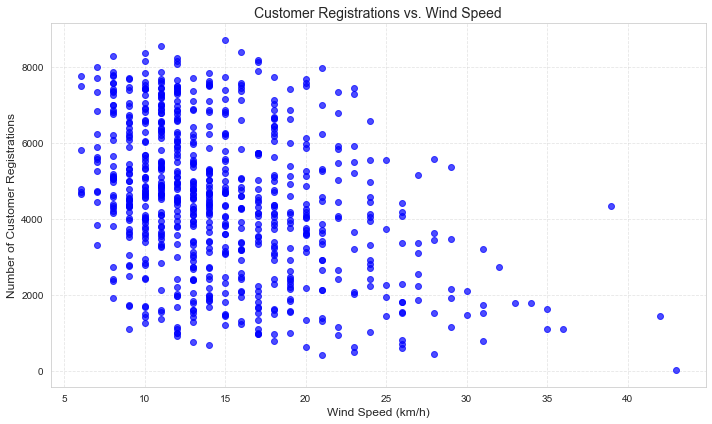

In [538]:
plt.scatter(df['windspeed_km/h'], df['total'], color='blue', alpha=0.7)
plt.xlabel('Wind Speed (km/h)', fontsize=12)
plt.ylabel('Number of Customer Registrations', fontsize=12)
plt.title('Customer Registrations vs. Wind Speed', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjusting plot aesthetics
plt.gcf().set_size_inches(10, 6)  # Set the figure size
plt.tight_layout()  # Improve spacing between elements

# Displaying the plot
plt.show()

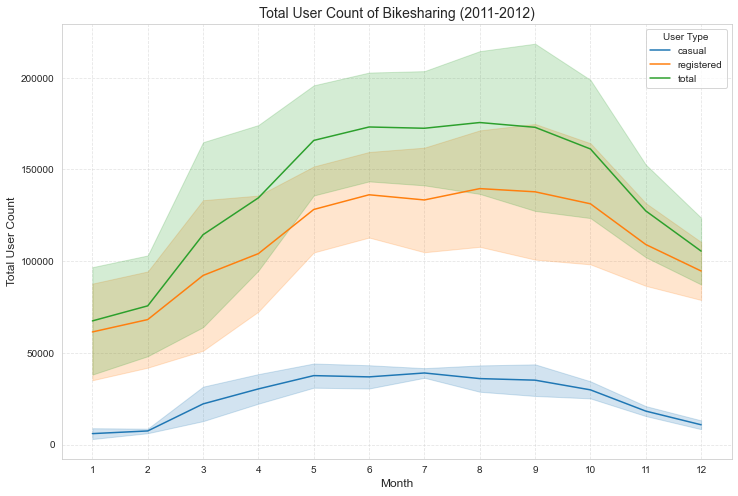

In [539]:
filtered_df = df.resample('M', on='dtime').sum()

# Reset the index to have a separate column for the month
filtered_df = filtered_df.reset_index()

# Melt the data to have a single column for the user type
filtered_df = filtered_df.melt(id_vars='dtime',
                               value_vars=['casual', 'registered', 'total'],
                               var_name='user_type',
                               value_name='count')

# Plotting the data
sns.lineplot(x=filtered_df['dtime'].dt.month, y='count', hue='user_type', data=filtered_df)

# Set labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total User Count', fontsize=12)
plt.title('Total User Count of Bikesharing (2011-2012)', fontsize=14)

# Set legend
plt.legend(title='User Type')

# Adjusting plot aesthetics
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)

# Set figure size
plt.gcf().set_size_inches(12, 8)

# Display the plot
plt.show()

In [540]:
total_registered = df['registered'].sum()
total_casual = df['casual'].sum()

# Calculate the percentage of registered and casual users
percentage_registered = (total_registered / (total_registered + total_casual)) * 100
percentage_casual = (total_casual / (total_registered + total_casual)) * 100

# Print the results
print(f"Percentage of Registered Users: {percentage_registered:.2f}%")
print(f"Percentage of Casual Users: {percentage_casual:.2f}%")

Percentage of Registered Users: 81.17%
Percentage of Casual Users: 18.83%


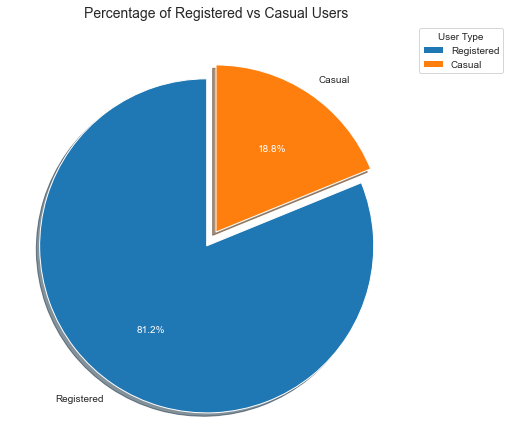

In [541]:
# Calculate the total count of registered and casual users
total_registered = df['registered'].sum()
total_casual = df['casual'].sum()

# Calculate the percentage of registered and casual users
percentage_registered = (total_registered / (total_registered + total_casual)) * 100
percentage_casual = (total_casual / (total_registered + total_casual)) * 100

# Create a pie chart
labels = ['Registered', 'Casual']
sizes = [percentage_registered, percentage_casual]
colors = ['#1f77b4', '#ff7f0e']
explode = (0.1, 0)  # Explode the first slice (Registered)

# Create a figure and axis with equal aspect ratio
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Create the pie chart with custom colors, explode, and shadow
wedges, _, text_labels = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                autopct='%1.1f%%', startangle=90, shadow=True)

# Set the text color of percentage labels to white
for text_label in text_labels:
    text_label.set_color('white')

# Set the font size of the labels and percentage labels
ax.set_title('Percentage of Registered vs Casual Users', fontsize=14)
legend = ax.legend(title='User Type', loc='upper right', fontsize=10)
ax.axis('off')

# Improve spacing between the pie and the title
plt.subplots_adjust(top=0.85)

# Set legend to be outside the pie chart
legend.set_bbox_to_anchor((1.2, 1))

# Display the chart
plt.show()

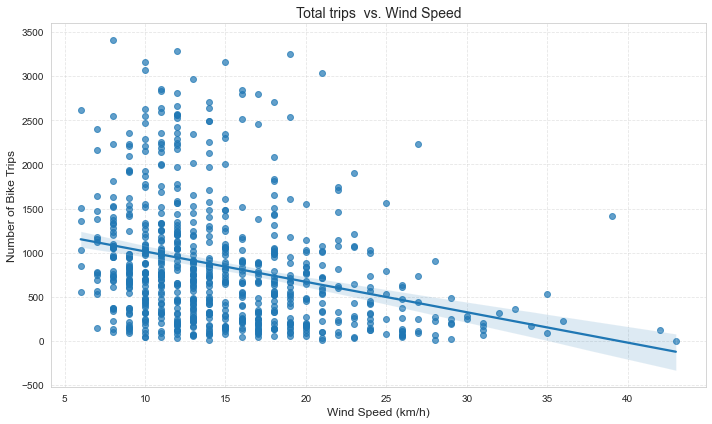

In [542]:
sns.regplot(x=df['windspeed_km/h'], y=df['casual'], scatter_kws={'alpha': 0.7})
plt.xlabel('Wind Speed (km/h)', fontsize=12)
plt.ylabel('Number of Bike Trips', fontsize=12)
plt.title('Total trips  vs. Wind Speed', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjusting plot aesthetics
plt.gcf().set_size_inches(10, 6)  # Set the figure size
plt.tight_layout()  # Improve spacing between elements

# Displaying the plot
plt.show()

In [543]:
df.head()

,dtime,season_name,season_num,weekday,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat
0,2011-01-01,Winter,1,6,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,S,low
1,2011-01-02,Winter,1,0,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,NW,low
2,2011-01-03,Winter,1,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,NW,low
3,2011-01-04,Winter,1,2,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,SW,low
4,2011-01-05,Winter,1,3,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,NW,low


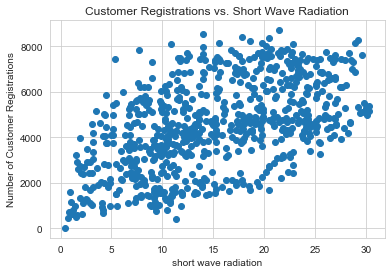

In [544]:
# Plotting the data
plt.scatter(df['shortwave_radiation_MJ/m²'], df['total'])
plt.xlabel('short wave radiation')
plt.ylabel('Number of Customer Registrations')
plt.title('Customer Registrations vs. Short Wave Radiation')
plt.show()

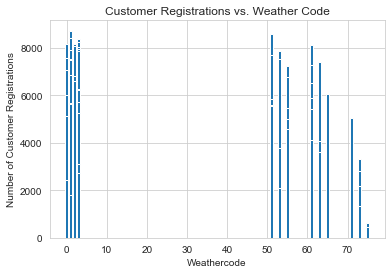

In [545]:
# Plotting the data
plt.bar(df['weathercode_wmo code'], df['total'])
plt.xlabel('Weathercode')
plt.ylabel('Number of Customer Registrations')
plt.title('Customer Registrations vs. Weather Code')
plt.show()

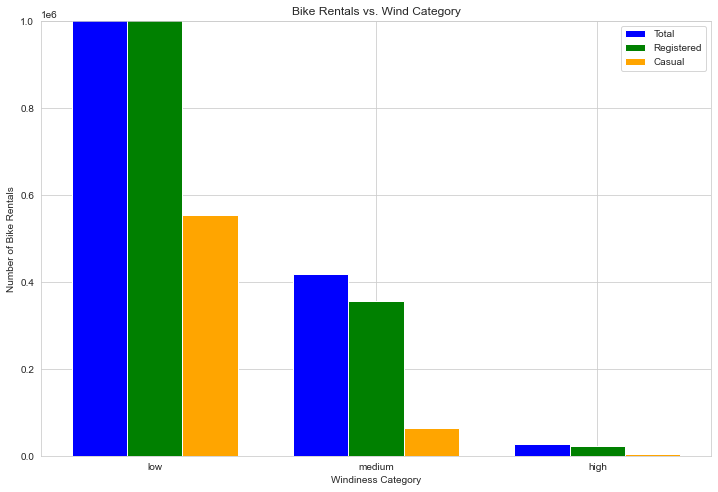

In [546]:
import numpy as np


# Group the data by the "windy_cat" column and calculate the sum for each category
grouped_df = df.groupby('windy_cat').sum()

# Define the desired order of wind categories
wind_categories = ['low', 'medium', 'high']

# Reindex the grouped dataframe based on the desired order
grouped_df = grouped_df.reindex(wind_categories)

# Get the values for "total", "registered", and "casual" columns
total_values = grouped_df['total'].tolist()
registered_values = grouped_df['registered'].tolist()
casual_values = grouped_df['casual'].tolist()

# Set the width of each bar
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(wind_categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(r1, total_values, color='blue', width=bar_width, label='Total')
plt.bar(r2, registered_values, color='green', width=bar_width, label='Registered')
plt.bar(r3, casual_values, color='orange', width=bar_width, label='Casual')

# Set x-axis labels and tick positions
plt.xlabel('Windiness Category')
plt.xticks([r + bar_width for r in range(len(wind_categories))], wind_categories)

# Set y-axis label
plt.ylabel('Number of Bike Rentals')

# Set plot title
plt.title('Bike Rentals vs. Wind Category')

# Set legend
plt.legend()

# Set the desired range for the y-axis
plt.ylim(0, 1000000)  # Adjust the values based on your dataset

# Display the plot
plt.show()

In [547]:
df.head()

,dtime,season_name,season_num,weekday,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat
0,2011-01-01,Winter,1,6,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,S,low
1,2011-01-02,Winter,1,0,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,NW,low
2,2011-01-03,Winter,1,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,NW,low
3,2011-01-04,Winter,1,2,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,SW,low
4,2011-01-05,Winter,1,3,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,NW,low


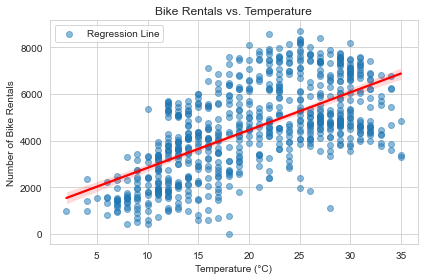

In [548]:
sns.set_style("whitegrid")

# Create a scatter plot with regression line
sns.regplot(data=df, x='temp_celsius', y='total', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# Set the plot labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Bike Rentals')
plt.title('Bike Rentals vs. Temperature')

# Set the plot aesthetics
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a descriptive legend
plt.legend(['Regression Line'], loc='best')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [549]:
df.head()

,dtime,season_name,season_num,weekday,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat
0,2011-01-01,Winter,1,6,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,S,low
1,2011-01-02,Winter,1,0,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,NW,low
2,2011-01-03,Winter,1,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,NW,low
3,2011-01-04,Winter,1,2,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,SW,low
4,2011-01-05,Winter,1,3,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,NW,low


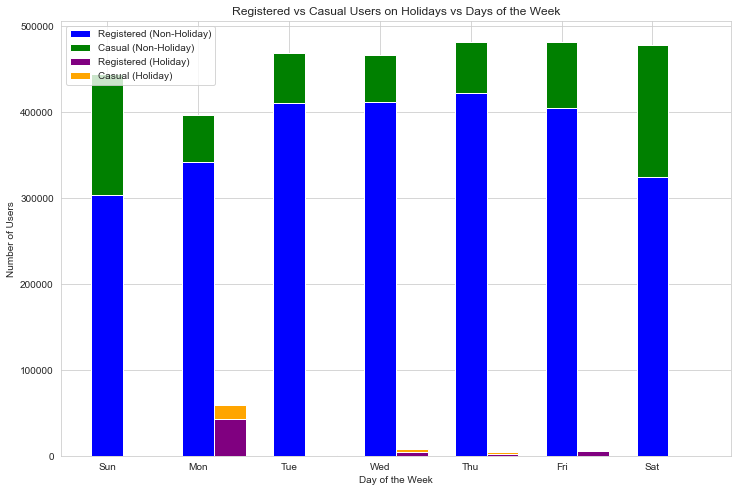

In [550]:
all_weekdays = range(0, 7)  # Adjusted the range to start from 0 (Sunday)
all_holidays = [0, 1]
df_extended = pd.DataFrame([(weekday, holiday) for weekday in all_weekdays for holiday in all_holidays], columns=['weekday', 'holiday'])
grouped_df_extended = df_extended.merge(df, on=['weekday', 'holiday'], how='left').groupby(['weekday', 'holiday']).sum().reset_index()

# Set the order of weekdays
weekday_order = all_weekdays

# Filter the data for registered and casual user counts
registered_counts = grouped_df_extended.loc[grouped_df_extended['holiday'] == 0, 'registered']
casual_counts = grouped_df_extended.loc[grouped_df_extended['holiday'] == 0, 'casual']
holiday_registered_counts = grouped_df_extended.loc[grouped_df_extended['holiday'] == 1, 'registered']
holiday_casual_counts = grouped_df_extended.loc[grouped_df_extended['holiday'] == 1, 'casual']

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = weekday_order
r2 = [x + bar_width for x in r1]
fig, ax = plt.subplots(figsize=(12, 8))
# Create a bar plot for non-holidays
plt.bar(r1, registered_counts, color='blue', width=bar_width, label='Registered (Non-Holiday)')
plt.bar(r1, casual_counts, color='green', width=bar_width, bottom=registered_counts, label='Casual (Non-Holiday)')

# Create a bar plot for holidays
plt.bar(r2, holiday_registered_counts, color='purple', width=bar_width, label='Registered (Holiday)')
plt.bar(r2, holiday_casual_counts, color='orange', width=bar_width, bottom=holiday_registered_counts, label='Casual (Holiday)')

# Set the plot labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Users')
plt.title('Registered vs Casual Users on Holidays vs Days of the Week')

# Set the x-axis tick positions and labels
plt.xticks(weekday_order, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])  # Adjusted the tick labels

# Set the legend
plt.legend()

# Show the plot
plt.show()

In [551]:
df.groupby(df['dtime'].dt.year)['total'].mean()

dtime
2011    3405.761644
2012    5599.934426
Name: total, dtype: float64

In [552]:
windy_users = df.groupby('windy_cat', as_index=False).agg({'registered': 'mean', 'casual': 'mean'})

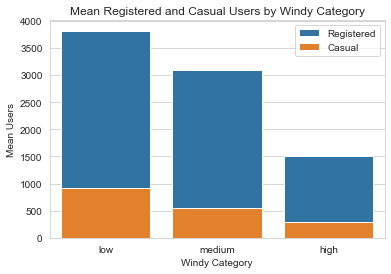

In [553]:
colors = ["#1f77b4", "#ff7f0e"]
my_order = ['low','medium','high']
sns.barplot(data=windy_users, x='windy_cat', y='registered', label='Registered', color=colors[0],order=my_order)
sns.barplot(data=windy_users, x='windy_cat', y='casual', label='Casual', color=colors[1],order=my_order)

plt.xlabel('Windy Category')
plt.ylabel('Mean Users')
plt.title('Mean Registered and Casual Users by Windy Category')
plt.legend()
plt.show()

In [554]:
windy_users = df.groupby('windy_cat').agg({'registered': 'mean', 'casual': 'mean'})

# Calculate the drop-off for casual users compared to registered users
drop_off = (windy_users['casual'] - windy_users['registered'])

# Calculate the proportionate drop-off
proportionate_drop_off = drop_off / drop_off.max()

# Display the proportionate drop-off values
print(proportionate_drop_off)

windy_cat
high      1.000000
low       2.389719
medium    2.105227
dtype: float64


In [555]:
totalper = df.groupby(df['dtime'].dt.year).agg({'registered': 'sum', 'casual': 'sum'})

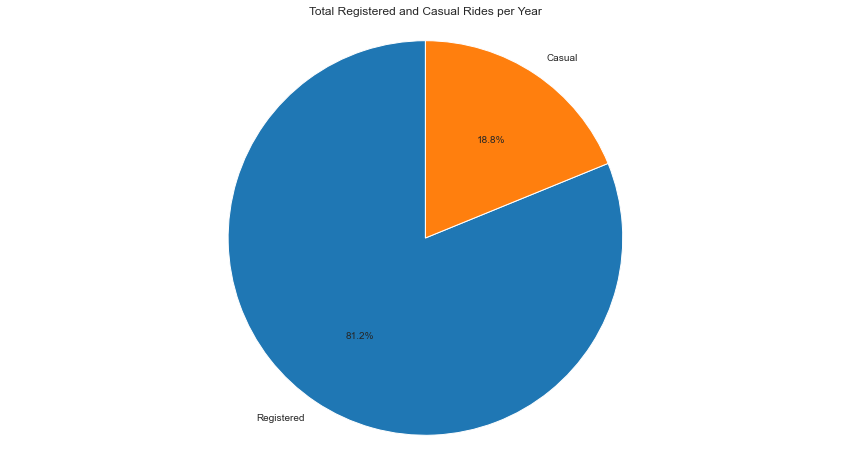

In [556]:
total_per = df.groupby(df['dtime'].dt.year, as_index=False).agg({'registered': 'sum', 'casual': 'sum'})
fig,ax=plt.subplots(figsize=(15,8))
labels = ['Registered', 'Casual']
sizes = [total_per['registered'].sum(), total_per['casual'].sum()]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Total Registered and Casual Rides per Year')
plt.show()

In [557]:
total_per

,registered,casual
0,995851,247252
1,1676811,372765


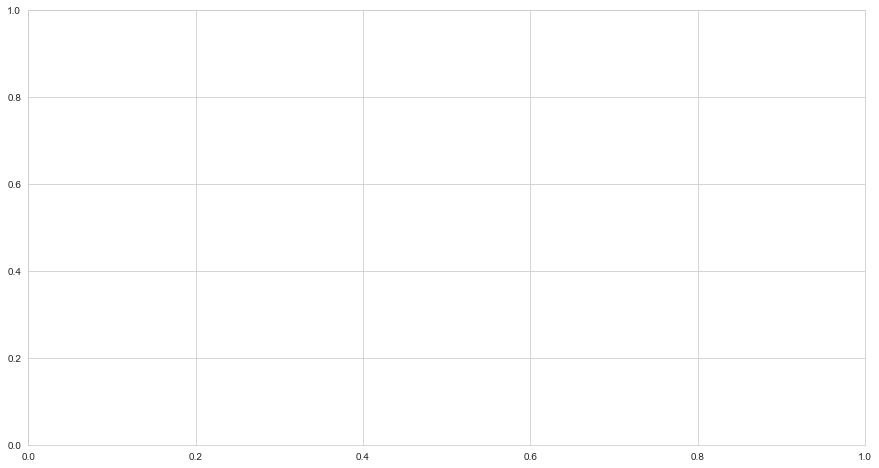

In [558]:
fig,ax=plt.subplots(figsize=(15,8))

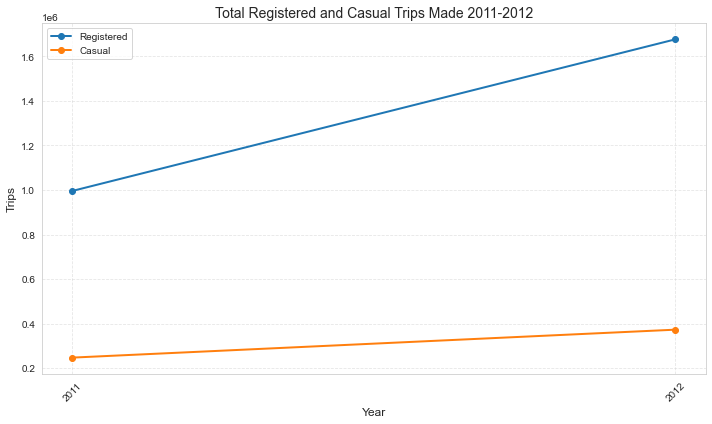

In [559]:
total_per = df.groupby(df['dtime'].dt.year).agg({'registered': 'sum', 'casual': 'sum'})

years = total_per.index
registered_users = total_per['registered']
casual_users = total_per['casual']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the lines
ax.plot(years, registered_users, marker='o', label='Registered', linewidth=2)
ax.plot(years, casual_users, marker='o', label='Casual', linewidth=2)

# Customize the plot appearance
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.set_title('Total Registered and Casual Trips Made 2011-2012', fontsize=14)
ax.legend(fontsize=10)

# Set x-axis tick labels and rotation
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45, fontsize=10)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Adjust spacing
fig.tight_layout()

# Show the plot
plt.show()

In [560]:
df.head()

,dtime,season_name,season_num,weekday,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat
0,2011-01-01,Winter,1,6,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,S,low
1,2011-01-02,Winter,1,0,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,NW,low
2,2011-01-03,Winter,1,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,NW,low
3,2011-01-04,Winter,1,2,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,SW,low
4,2011-01-05,Winter,1,3,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,NW,low


In [561]:

# Assuming df_complete contains the 'weekday' column with values 0-6 representing weekdays.

# Perform one-hot encoding using pandas get_dummies function
df_encoded = pd.get_dummies(df, columns=['weekday'], prefix='day', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
print(df_encoded.head())

       dtime season_name  season_num  holiday  workingday  weathersit  hum  \
0 2011-01-01      Winter           1        0           0           2   80   
1 2011-01-02      Winter           1        0           0           2   69   
2 2011-01-03      Winter           1        0           1           1   43   
3 2011-01-04      Winter           1        0           1           1   59   
4 2011-01-05      Winter           1        0           1           1   43   

   windspeed  casual  registered  total  temp_celsius  temp_celsius_realfeel  \
0  10.749882     331         654    985            14                     18   
1  16.652113     131         670    801            15                     18   
2  16.636703     120        1229   1349             8                      9   
3  10.739832     108        1454   1562             8                     11   
4  12.522300      82        1518   1600             9                     11   

   weathercode_wmo code  temp_max  temp_min  preci

In [562]:
df_encoded['rainy'] = df_encoded['precipitation_sum_mm'].apply(lambda x: 'yes' if x > 0.3 else 'no')

In [563]:
df_encoded['rainy'].value_counts()

no     436
yes    295
Name: rainy, dtype: int64

In [564]:
df_encoded = pd.get_dummies(df_encoded, columns=['rainy'], prefix='rainy', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

,dtime,season_name,season_num,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,wind_direction,windy_cat,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes
0,2011-01-01,Winter,1,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,S,low,0,0,0,0,0,0,1,0,1
1,2011-01-02,Winter,1,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,NW,low,1,0,0,0,0,0,0,0,1
2,2011-01-03,Winter,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,NW,low,0,1,0,0,0,0,0,1,0
3,2011-01-04,Winter,1,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,SW,low,0,0,1,0,0,0,0,1,0
4,2011-01-05,Winter,1,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,NW,low,0,0,0,1,0,0,0,1,0


In [565]:
df_encoded = pd.get_dummies(df_encoded, columns=['wind_direction'], prefix='wind_direct', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

,dtime,season_name,season_num,holiday,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,windy_cat,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes,wind_direct_,wind_direct_E,wind_direct_NE,wind_direct_NW,wind_direct_S,wind_direct_SE,wind_direct_SW,wind_direct_W
0,2011-01-01,Winter,1,0,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,low,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
1,2011-01-02,Winter,1,0,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,low,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2011-01-03,Winter,1,0,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,low,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,2011-01-04,Winter,1,0,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,low,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,2011-01-05,Winter,1,0,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,low,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [566]:
df_encoded.rename(columns={'wind_direct_':'wind_direct_N'},inplace=True)

In [567]:
df_encoded = pd.get_dummies(df_encoded, columns=['holiday'], prefix='holiday', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

,dtime,season_name,season_num,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,windy_cat,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes,wind_direct_N,wind_direct_E,wind_direct_NE,wind_direct_NW,wind_direct_S,wind_direct_SE,wind_direct_SW,wind_direct_W,holiday_0,holiday_1
0,2011-01-01,Winter,1,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,low,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
1,2011-01-02,Winter,1,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,low,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,2011-01-03,Winter,1,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,low,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,2011-01-04,Winter,1,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,low,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,2011-01-05,Winter,1,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,low,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [568]:
# Create a lag feature for the 'bike_trips' column with a lag of 1 hour:
df_encoded['casual_count_lag1'] = df_encoded['casual'].shift(1)

# The 'bike_trips_lag1' column will now contain the 'bike_trips' values shifted one hour backward.
# The first row will have a NaN value as there's no previous value to shift.

# Let's see the resulting DataFrame with the lag feature:
print(df_encoded.head())


       dtime season_name  season_num  workingday  weathersit  hum  windspeed  \
0 2011-01-01      Winter           1           0           2   80  10.749882   
1 2011-01-02      Winter           1           0           2   69  16.652113   
2 2011-01-03      Winter           1           1           1   43  16.636703   
3 2011-01-04      Winter           1           1           1   59  10.739832   
4 2011-01-05      Winter           1           1           1   43  12.522300   

   casual  registered  total  temp_celsius  temp_celsius_realfeel  \
0     331         654    985            14                     18   
1     131         670    801            15                     18   
2     120        1229   1349             8                      9   
3     108        1454   1562             8                     11   
4      82        1518   1600             9                     11   

   weathercode_wmo code  temp_max  temp_min  precipitation_sum_mm  \
0                  61.0        14  

In [569]:
df_encoded['casual_count_lag1'] = df_encoded['casual_count_lag1'].fillna(method='bfill')

##### The National Cherry Blossom Festival, which runs from March 26 – April 10, 2011, Mar 20, 2012 – Apr 27, 2012

In [570]:
event_range1 = pd.date_range(start='2011-03-26', end='2011-04-10')
event_range2 = pd.date_range(start='2012-03-20', end='2012-04-27')

In [571]:
df_encoded['event'] = df_encoded['dtime'].apply(lambda x: 'yes' if x in event_range1 or x in event_range2 else 'no')

In [611]:
df_encoded = pd.get_dummies(df_encoded, columns=['event'], prefix='event', drop_first=False)

# The 'weekday' column has been one-hot encoded and replaced with new columns.
# The drop_first=True argument will drop the first one-hot encoded column to prevent multicollinearity.

# Let's see the resulting DataFrame with one-hot encoded columns
df_encoded.head()

,dtime,season_name,season_num,workingday,weathersit,hum,windspeed,casual,registered,total,temp_celsius,temp_celsius_realfeel,weathercode_wmo code,temp_max,temp_min,precipitation_sum_mm,windspeed_km/h,wind_direction_deg,shortwave_radiation_MJ/m²,windy_cat,day_0,day_1,day_2,day_3,day_4,day_5,day_6,rainy_no,rainy_yes,wind_direct_N,wind_direct_E,wind_direct_NE,wind_direct_NW,wind_direct_S,wind_direct_SE,wind_direct_SW,wind_direct_W,holiday_0,holiday_1,casual_count_lag1,event_no,event_yes
0,2011-01-01,Winter,1,0,2,80,10.749882,331,654,985,14,18,61.0,14,1,2.5,17,197.0,5.59,low,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,331.0,1,0
1,2011-01-02,Winter,1,0,2,69,16.652113,131,670,801,15,18,55.0,13,1,3.0,18,299.0,1.25,low,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,331.0,1,0
2,2011-01-03,Winter,1,1,1,43,16.636703,120,1229,1349,8,9,1.0,3,-3,0.0,17,299.0,10.22,low,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,131.0,1,0
3,2011-01-04,Winter,1,1,1,59,10.739832,108,1454,1562,8,11,1.0,6,-4,0.0,11,215.0,9.93,low,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,120.0,1,0
4,2011-01-05,Winter,1,1,1,43,12.522300,82,1518,1600,9,11,1.0,4,-4,0.0,13,314.0,9.22,low,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,108.0,1,0


### ML Linear Regression


In [573]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [612]:
X = df_encoded[['temp_celsius', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6','rainy_yes', 'holiday_1', 'casual_count_lag1', 'event_yes']]
y = df_encoded['casual'] 


In [613]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [614]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [615]:
y_pred = model.predict(X_test)

In [616]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,casual_count_lag1,2.59
5,day_4,2.58
4,day_3,2.38
1,day_0,2.35
2,day_1,2.34
3,day_2,2.29
6,day_5,2.19
7,day_6,2.18
0,temp_celsius,1.88
9,holiday_1,1.12


In [617]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 249.42
Mean Squared Error (MSE): 117507.04
Root Mean Squared Error (RMSE): 342.79
R-squared (R2): 0.70


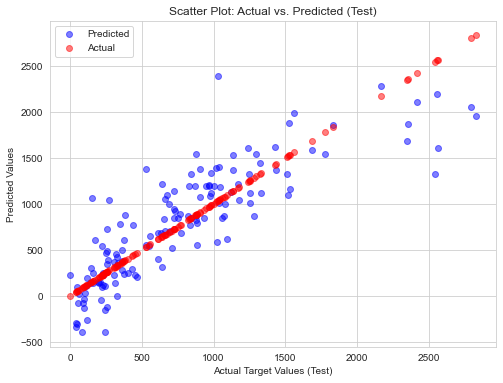

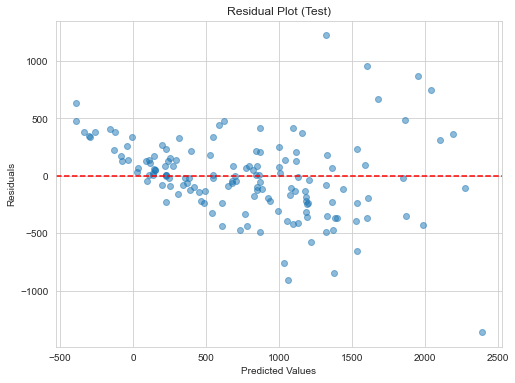

In [618]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test)')
plt.grid(True)
plt.show()

In [619]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Assuming you have your feature matrix X and target vector y ready
# Let's assume X and y are pandas DataFrames with a datetime index

# Handle any missing values in X and y
X = X.dropna()
y = y.dropna()

# Ensure X and y have the same index and are aligned correctly
X, y = X.align(y, axis=0, join='inner')

# Define the number of splits (number of rolling windows)
n_splits = 5

# Initialize the Rolling Window Time Series Split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

# Initialize your model (e.g., Linear Regression)
model = LinearRegression()

# Perform Rolling Window Cross-Validation
for train_index, test_index in rolling_cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model on the testing data
    y_pred = model.predict(X_test)

    # Calculate and print evaluation metrics (e.g., MSE, MAE, R2) for each fold
    mse = np.mean((y_test - y_pred) ** 2)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = model.score(X_test, y_test)

    print(f"Fold - MSE: {mse}, MAE: {mae}, R2: {r2}")

Fold - MSE: 153113.18316012924, MAE: 281.96129389791747, R2: 0.46337744239189305
Fold - MSE: 67227.60086492344, MAE: 186.78510153304967, R2: 0.7189375851188009
Fold - MSE: 196383.99840991772, MAE: 277.93212264806266, R2: 0.6133841108903413
Fold - MSE: 237942.15112952597, MAE: 356.29027407247895, R2: 0.4724758584865527
Fold - MSE: 162893.39913041165, MAE: 283.45133471753104, R2: 0.6781774155437228


### Polynomial

In [582]:
from sklearn.preprocessing import PolynomialFeatures

In [622]:
X = df_encoded[
    ['temp_celsius', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5','day_6','rainy_yes', 'holiday_1', 'event_yes']
                 ]

y = df_encoded['casual'] 

In [623]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [624]:
degree = 2 # Choose the degree of the polynomial (you can adjust this value)
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [625]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [626]:
y_pred = model.predict(X_test_poly)

In [627]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 255.97
Mean Squared Error (MSE): 124596.85
Root Mean Squared Error (RMSE): 352.98
R-squared (R2): 0.68


In [628]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,day_4,2.35
2,day_1,2.28
4,day_3,2.19
1,day_0,2.17
3,day_2,2.17
7,day_6,2.12
6,day_5,2.05
9,holiday_1,1.12
0,temp_celsius,1.03
8,rainy_yes,1.03


In [629]:
df_encoded['casual']

0      331
1      131
2      120
3      108
4       82
      ... 
726    247
727    644
728    159
729    364
730    439
Name: casual, Length: 731, dtype: int64

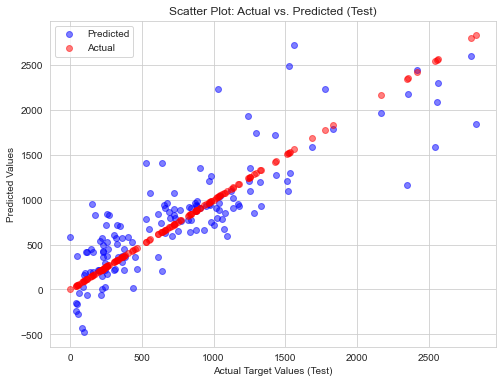

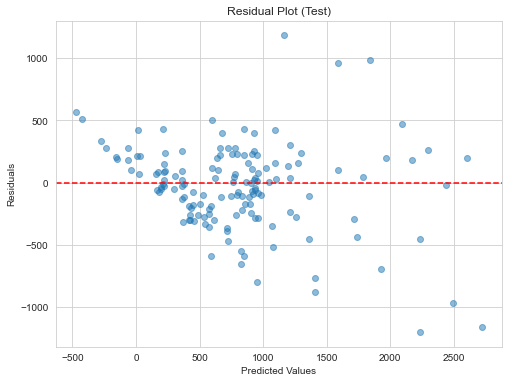

In [630]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test)')
plt.grid(True)
plt.show()

### Support Vector Regressor


In [639]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [640]:
X = df_encoded[
    ['temp_celsius', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5','day_6','rainy_yes', 'holiday_1', 'casual_count_lag1',
     'event_yes']
                 ]

y = df_encoded['casual'] 

In [641]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [642]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [643]:
svr_model = SVR(C= 10.0, epsilon= 0.1, kernel= 'linear')  # You can experiment with different kernels and hyperparameters
svr_model.fit(X_train_scaled, y_train)

SVR(C=10.0, kernel='linear')

In [644]:
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Penalty parameter C of the error term
    'kernel': ['linear', 'rbf'],  # Kernel type to use
    'epsilon': [0.01, 0.1, 0.5]  # Epsilon in the epsilon-SVR model
}

In [645]:
# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and metrics 
print("Best Hyperparameters:", best_params)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Best Hyperparameters: {'C': 10.0, 'epsilon': 0.5, 'kernel': 'linear'}
Mean Absolute Error (MAE): 229.75
Mean Squared Error (MSE): 113368.13
Root Mean Squared Error (RMSE): 336.70
R-squared (R2): 0.71


#### Gridsearch Results

- Best Hyperparameters: {'C': 10.0, 'epsilon': 0.5, 'kernel': 'linear'}
- Mean Absolute Error (MAE): 229.75
- Mean Squared Error (MSE): 113368.13
- Root Mean Squared Error (RMSE): 336.70
- R-squared (R2): 0.71


In [646]:
y_pred = svr_model.predict(X_test_scaled)

In [647]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 229.75
Mean Squared Error (MSE): 113373.59
Root Mean Squared Error (RMSE): 336.71
R-squared (R2): 0.71


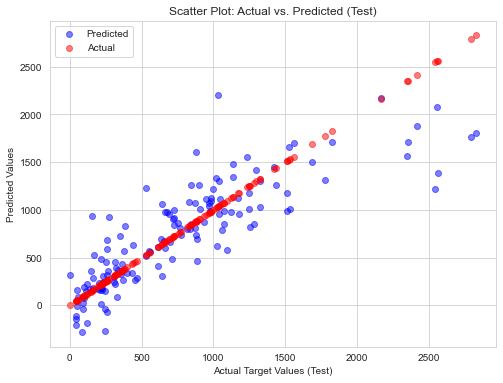

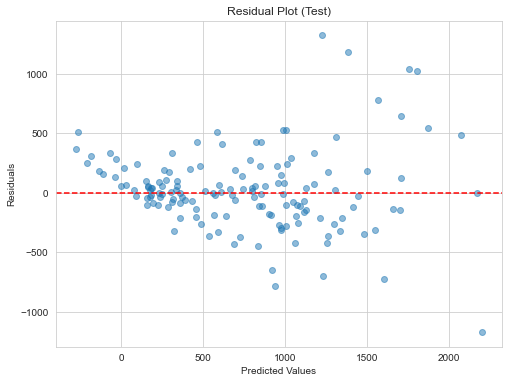

In [648]:
# Scatter plot
# Scatter plot with different colors for actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)  # Predicted values in blue
plt.scatter(y_test, y_test, color='red', label='Actual', alpha=0.5)  # Actual target values in red
plt.xlabel('Actual Target Values (Test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test)')
plt.grid(True)
plt.show()